# 2022 예능

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [2]:
df = pd.read_csv('./data_program/2022년 화제 예능.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20221214,"<나는 솔로>, <환승연애2>, <돌싱글즈3> 등 연애 예능 '3대장'이 이끈 20...","<나는 솔로>, <환승연애2>, <돌싱글즈3> 등 연애 <b>예능<\/b> '3대장...","[2022년 예능 결산] 연애 예능 대약진 vs 댄스,경연 예능 주춤"
1,20230101,어느덧 새해가 밝았다! 이렇게 지나가버린 2022년을 나중에 조금이라도 더 기억을 ...,아마 <b>2022년<\/b> 최고의 신인이 아닐까 한다. 놀면 뭐하니의 WSG워너...,"2022년을 돌아보며 ... 내가 선정한 2022년 최고의 인물, 음악, 영화, 그..."
2,20220908,2022 SBS 동물농장 특별기획 2부작 탑독(TOPDOG) 🐶🐶🐶 죽음의 교도소 ...,그리고 TV 동물농장 역사상 최강의 수색 능력으로 큰 <b>화제<\/b>를 모았던 ...,SBS 예능 추석특집 예능 동물농장 2022년 9월11일 오전 9시 30분 탑독 역...
3,20221207,얼마 남지 않은 2022년 12월 공개예정인 넷플릭스 오리지널 드라마 영화 예능이 ...,얼마 남지 않은 <b>2022년<\/b> 12월 공개예정인 넷플릭스 오리지널 드라마...,2022년 넷플릭스 오리지널 12월 공개예정 드라마 영화 예능 라인업
4,20221220,한국갤럽에서는 2013년 1월부터 매달 '한국인이 좋아하는 TV프로그램'을 조사해 ...,시리즈) <b>2022년<\/b>은 전반적인 상위권 <b>예능<\/b>의 침체가 있...,2022년 예능 선호도 종합 TOP10 총결산 - 올해 가장 인기 있었던 예능은? ...


## 1. 전처리

In [3]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [4]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = [
'예능', '2022년', '화제', '방송', '출연', '드라마', '프로그램', '배우', '사람', '공개', '대하',
'모습', '영화', '시즌', '시작', '사랑', '활동', '생각', '콘텐츠', '인기', '작품', '이야기', '멤버',
'영상', '가수', '사진', '이후', '연기', '보이', '데뷔', '시청', '채널', '이후', '오리지널', '사람',
'활동', '출연진', '대상', '정보', '방송', '프로필', '추천', '나이', '예정', '이유', '대상',
'근황', '인스타', '배우', '한국', '소식', '때문', '다양', '출처', '진행', '당시', '정도', '대표',
'마음', '관심', '남자', '선수', '제작', '등장'
]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = 'stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [5]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [6]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 50.9 s
Wall time: 3min 44s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20221214,나는 솔로 환승연애2 돌싱글즈3 등 연애 예능 3대장이 이끈 2022년 2022년 ...,나는 솔로 환승연애2 돌싱글즈3 등 연애 b예능b 3대장이 이끈 b2022년b b2...,2022년 예능 결산 연애 예능 대약진 vs 댄스경연 예능 주춤,솔로 환승 연애 돌 싱글즈 연애 대 장 끈 주도 소재 단언 연애 과거 사이 하트 시...,솔로 환승 연애 돌 싱글즈 연애 대 장 끈 주도 소재 연애 대 장 성공 몰이 케이블 종편,결산 연애 약진 댄스 경연
1,20230101,어느덧 새해가 밝았다 이렇게 지나가버린 2022년을 나중에 조금이라도 더 기억을 할...,아마 b2022년b 최고의 신인이 아닐까 한다 놀면 뭐하니의 WSG워너비도 b화제b...,2022년을 돌아보며 내가 선정한 2022년 최고의 인물 음악 영화 그리고 예능유튜브,새해 중 라 기억 수 개인 선정 최고 인물 음악 유튜브 기록 주관 요소 재미 주 시...,최고 신인 워너비 개인 선정 최고 유튜브 컨텐츠 대학 도시 아재,선정 최고 인물 음악 유튜브
2,20220908,2022 SBS 동물농장 특별기획 2부작 탑독TOPDOG 죽음의 교도소 편 SBS ...,그리고 TV 동물농장 역사상 최강의 수색 능력으로 큰 b화제b를 모았던 인명구조견 ...,SBS 예능 추석특집 예능 동물농장 2022년 9월11일 오전 9시 30분 탑독 역...,동물 농장 특별 기획 부작 탑독 죽음 교도소 추석 특집 동물 농장 오전 시 분 탑독...,동물 농장 역사 강의 수색 능력 인명구조 견 제스퍼 초대 재난 주 추석 특집 동물 ...,추석 특집 동물 농장 오전 시 분 탑독 역대 거
3,20221207,얼마 남지 않은 2022년 12월 공개예정인 넷플릭스 오리지널 드라마 영화 예능이 ...,얼마 남지 않은 b2022년b 12월 공개예정인 넷플릭스 오리지널 드라마 영화 b예...,2022년 넷플릭스 오리지널 12월 공개예정 드라마 영화 예능 라인업,넷플릭스 만 라인업 적 달력 표시 중 기대작 거 연말 되 송혜교 주연 더 글로리 넷...,넷플릭스 솔로 지옥 오후 시 리얼리티 연애 지난해,넷플릭스 라인업
4,20221220,한국갤럽에서는 2013년 1월부터 매달 한국인이 좋아하는 TV프로그램을 조사해 순위...,시리즈 b2022년b은 전반적인 상위권 b예능b의 침체가 있었습니다 신규 프로그램들...,2022년 예능 선호도 종합 TOP10 총결산 올해 가장 인기 있었던 예능은 유 퀴...,한국갤럽 한국인 조사 순위 발표 블로그 갤럽 선호도 순위 순위 구성 고 한국갤럽 한...,시리즈 은 전반 상위 침체 신규 힘 물갈이 주 탓 니 유튜브 되 은 갤럽 반영 지,선호도 종합 결산 올해 은 유 퀴즈 온 더 블럭 위 싱어 게인 런닝맨 순


In [7]:
# 전처리한 결과 csv로 저장 
df.to_csv('22예능_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [8]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [9]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [10]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
15151,연애,1190
863,결혼,918
18076,이효리,911
775,게임,720
12603,스타,689
17248,음악,676
11461,세계,638
16989,유튜브,614
3824,넷플릭스,610
7438,무대,600


### [preprocessed_description]

In [11]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [12]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
2328,연애,111
1351,방영,74
158,결혼,71
598,넷플릭스,56
3733,티빙,56
1834,솔로,53
2643,음악,39
3244,지옥,37
1005,리얼리티,37
2448,올해,37


### [preprocessed_title]

In [13]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [14]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
1698,연애,58
103,결혼,44
445,넷플릭스,41
1358,솔로,33
2695,티빙,27
2346,지옥,26
1700,연예,25
2029,이혼,25
1442,스타,23
159,공식,23


## 3. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [15]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [16]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'연애': 1190,
 '결혼': 918,
 '이효리': 911,
 '게임': 720,
 '스타': 689,
 '음악': 676,
 '세계': 638,
 '유튜브': 614,
 '넷플릭스': 610,
 '무대': 600,
 '방영': 549,
 '광고': 504,
 '기대': 500,
 '솔로': 493,
 '아이돌': 490,
 '연출': 485,
 '서울': 481,
 '티빙': 473,
 '대한민국': 472,
 '연예': 471,
 '감독': 467,
 '기록': 467,
 '시청자': 466,
 '상황': 463,
 '사이': 462,
 '캐릭터': 456,
 '그룹': 452,
 '노래': 450,
 '이미지': 447,
 '올해': 444,
 '여자': 442,
 '소개': 440,
 '일본': 437,
 '생활': 435,
 '가능': 431,
 '국내': 423,
 '여행': 412,
 '시리즈': 411,
 '가족': 410,
 '커플': 407,
 '출연자': 405,
 '촬영': 403,
 '성공': 400,
 '공식': 400,
 '장르': 394,
 '이름': 394,
 '유재석': 393,
 '수상': 393,
 '최고': 391,
 '관련': 390,
 '친구': 388,
 '내용': 387,
 '이혼': 384,
 '매력': 376,
 '모델': 368,
 '소속사': 357,
 '가지': 352,
 '주연': 351,
 '경우': 351,
 '연예인': 344,
 '활약': 343,
 '유명': 336,
 '부부': 335,
 '앨범': 334,
 '개인': 333,
 '자리': 330,
 '미국': 329,
 '출신': 325,
 '지옥': 323,
 '여성': 323,
 '최근': 322,
 '김호중': 320,
 '세대': 319,
 '과거': 318,
 '반응': 317,
 '준비': 315,
 '졸업': 312,
 '프로': 312,
 '리얼리티': 310,
 '역할': 306,
 '처음': 306,
 '순위': 30

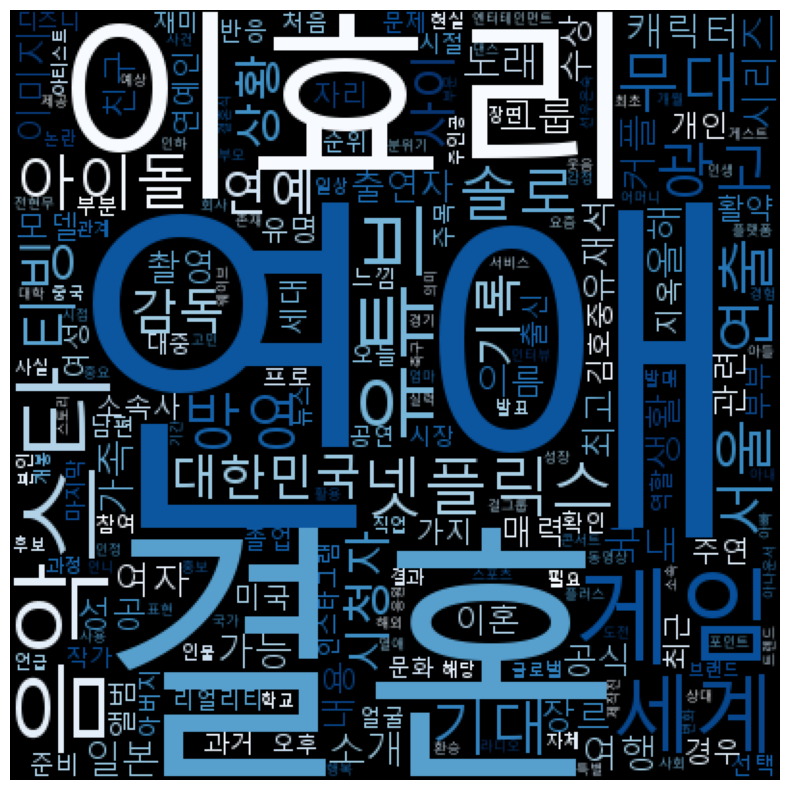

In [18]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

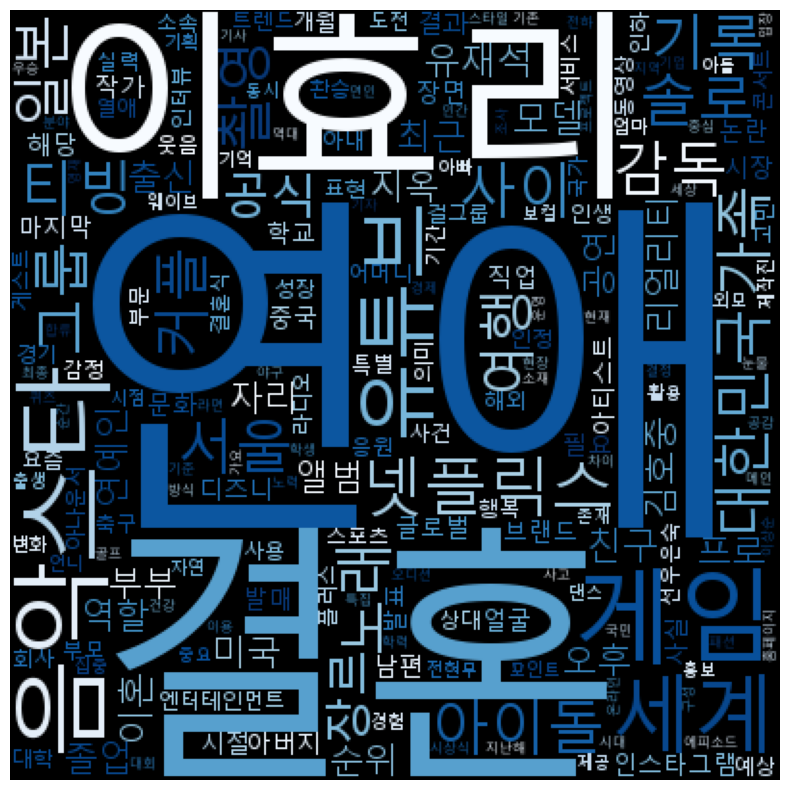

In [21]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'이미지', '관계', '부분', '방영', '세대', '상황', '반응', '재미', '연예',
             '유명', '세대', '처음', '연예', '일상', '유명', '출연자', '주목', '주인공',
             '무대', '광고', '개인', '캐릭터', '시리즈', '관련', '주연', '국내', '매력',
             '확인', '시청자', '내용', '내용', '소개', '뉴스', '인물', '가능', '준비',
             '대중', '올해', '선택', '자체', '이름', '언급', '오늘', '분위기', 
             '문제', '참여', '최고', '본인', '느낌', '활약', '스토리',
             '플랫폼', '과거', '기대', '여자', '생활', '여성', '성공', '경우', '최초',
             '연출', '사회', '현실', '가지', '생활', '개봉', '과정', '후보', '수상', '소속사'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [22]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'연애': 111,
 '방영': 74,
 '결혼': 71,
 '넷플릭스': 56,
 '티빙': 56,
 '솔로': 53,
 '음악': 39,
 '지옥': 37,
 '리얼리티': 37,
 '올해': 37,
 '오후': 30,
 '게임': 30,
 '유튜브': 30,
 '최근': 29,
 '이혼': 28,
 '수상': 28,
 '소개': 28,
 '최고': 27,
 '스타': 26,
 '사이': 26,
 '시리즈': 26,
 '환승': 25,
 '기록': 25,
 '특집': 25,
 '축구': 24,
 '오늘': 24,
 '활약': 24,
 '커플': 24,
 '공식': 23,
 '기간': 23,
 '금요일': 22,
 '퀴즈': 21,
 '여행': 21,
 '지나': 21,
 '출연자': 21,
 '무대': 20,
 '시점': 20,
 '대한민국': 20,
 '그룹': 20,
 '디즈니': 19,
 '연예': 19,
 '서울': 19,
 '목요일': 19,
 '유재석': 19,
 '순위': 19,
 '부부': 18,
 '일요일': 18,
 '중국': 18,
 '라인업': 18,
 '프로': 18,
 '아이돌': 18,
 '참견': 17,
 '최초': 17,
 '중심': 17,
 '생활': 17,
 '논란': 16,
 '장르': 16,
 '소속사': 16,
 '연출': 16,
 '웨이브': 16,
 '세대': 16,
 '작년': 16,
 '영재': 16,
 '촬영': 16,
 '조선': 16,
 '서바이벌': 16,
 '인물': 16,
 '국내': 16,
 '단독': 16,
 '대회': 16,
 '세계': 16,
 '걸그룹': 16,
 '과거': 15,
 '기준': 15,
 '하반기': 15,
 '야구': 15,
 '트로트': 15,
 '전지적': 15,
 '일상': 15,
 '캐릭터': 15,
 '화요일': 15,
 '열애': 15,
 '발매': 15,
 '개봉': 15,
 '김호중': 15,
 '결혼식': 14,
 '파일럿': 14,
 '출신': 14,
 '

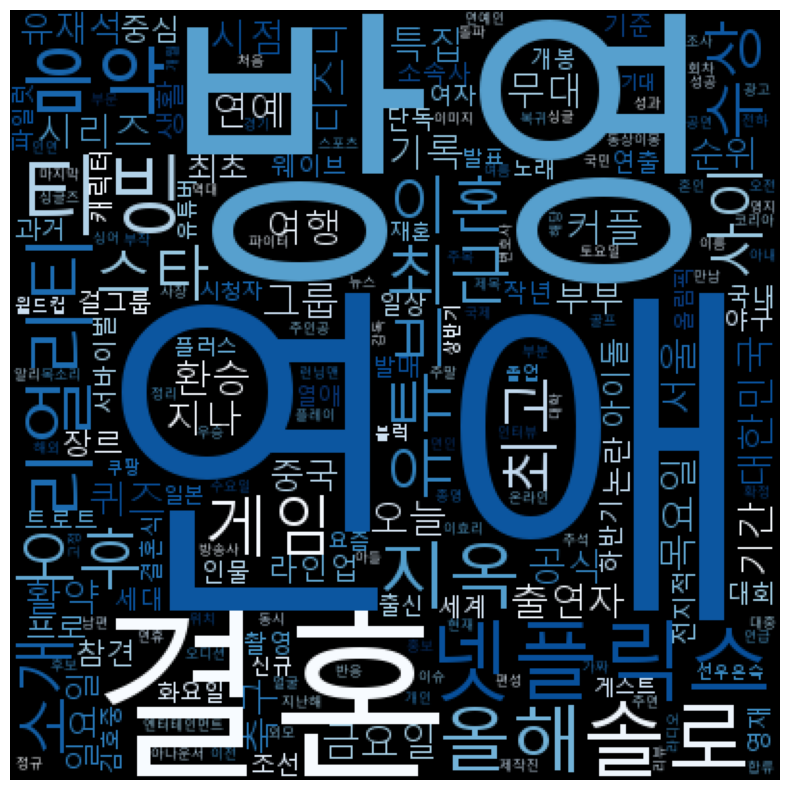

In [23]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

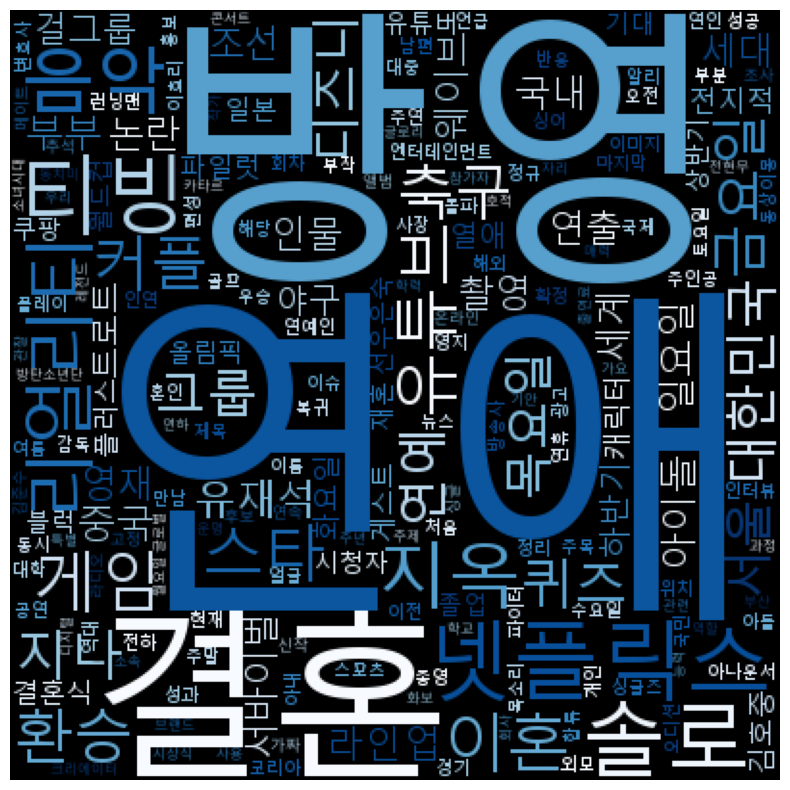

In [26]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'중심', '시리즈', '생활', '과거', '장르', '오후', '활약', '소개', '프로',
             '참견', '올해', '출연자', '출신', '최고', '최근', '기록', '단독', '특집',
             '소속사', '최초', '시점', '특집', '여자', '개봉', '무대', '소속사', '공식',
             '기간', '여행', '발표', '노래', '작년', '일상', '발매', '개월', '요즘', '오늘',
             '순위', '대회', '리뷰', '제작진', '부문', '사이', '지난해', '신규', '수상',
             '기준'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [27]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'연애': 58,
 '결혼': 44,
 '넷플릭스': 41,
 '솔로': 33,
 '티빙': 27,
 '지옥': 26,
 '연예': 25,
 '이혼': 25,
 '스타': 23,
 '공식': 23,
 '라인업': 22,
 '방영': 22,
 '신규': 20,
 '이슈': 18,
 '음악': 18,
 '게임': 18,
 '선우은숙': 17,
 '논란': 17,
 '유재석': 17,
 '열애': 17,
 '리뷰': 17,
 '직업': 16,
 '환승': 16,
 '아이돌': 16,
 '리얼리티': 15,
 '정리': 15,
 '연예인': 15,
 '후보': 15,
 '여자': 15,
 '여행': 15,
 '확정': 15,
 '유튜브': 14,
 '순위': 14,
 '트렌드': 14,
 '커플': 14,
 '부부': 14,
 '김호중': 14,
 '퀴즈': 14,
 '중국': 14,
 '런닝맨': 13,
 '소개': 13,
 '컴백': 12,
 '제목': 12,
 '상반기': 12,
 '세계': 12,
 '디즈니': 12,
 '기안': 11,
 '전현무': 11,
 '웨이브': 11,
 '공연': 11,
 '영재': 11,
 '블럭': 11,
 '신작': 11,
 '특집': 11,
 '지구': 10,
 '연휴': 10,
 '시리즈': 10,
 '오락실': 10,
 '플러스': 10,
 '결산': 10,
 '서울': 10,
 '부작': 10,
 '다큐': 10,
 '세대': 10,
 '수상': 10,
 '안내': 9,
 '임영웅': 9,
 '국민': 9,
 '와이프': 9,
 '무대': 9,
 '대상': 9,
 '최강': 9,
 '호적': 9,
 '과거': 9,
 '뉴스': 9,
 '유퀴즈': 9,
 '걸그룹': 9,
 '결별': 9,
 '싱글즈': 9,
 '촬영지': 9,
 '메이트': 9,
 '자녀': 8,
 '글로리': 8,
 '대세': 8,
 '동상이몽': 8,
 '목요일': 8,
 '서바이벌': 8,
 '맛집': 8,
 '이효리': 8,
 '남편': 8,


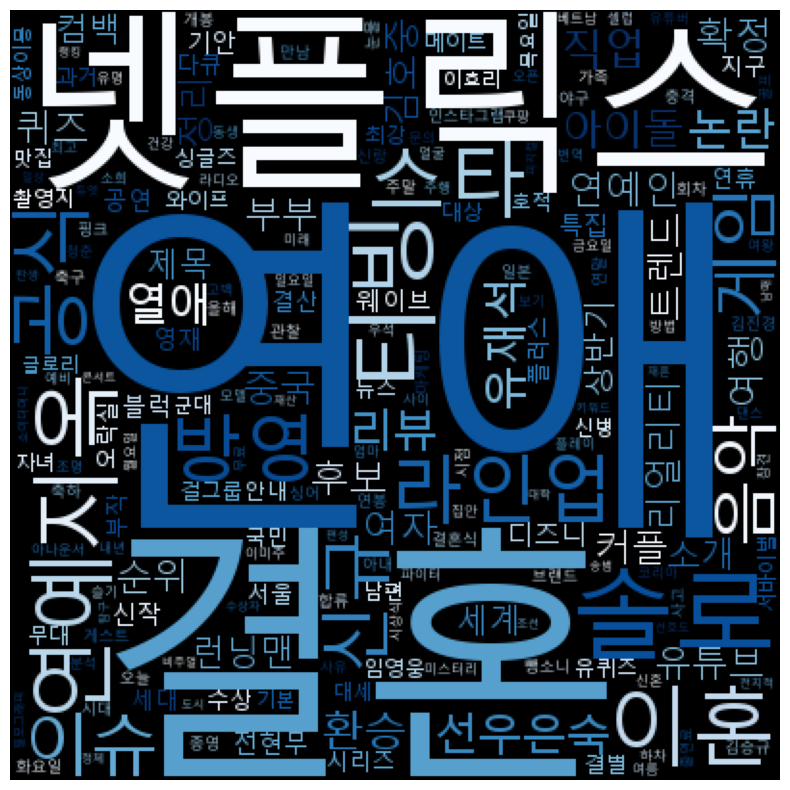

In [28]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

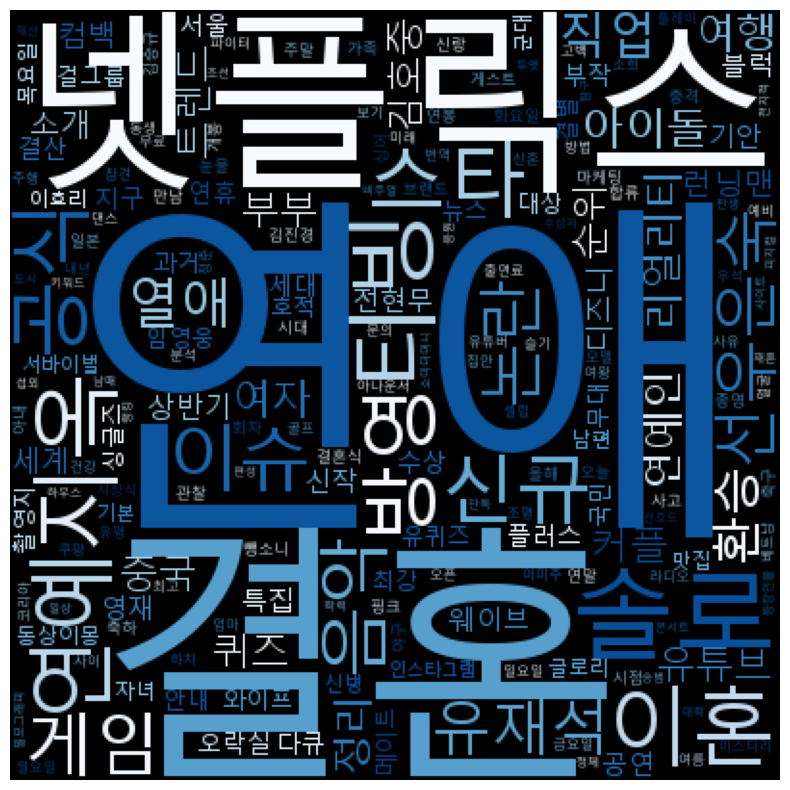

In [29]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'제목', '라인업', '후보', '리뷰', '확정', '시리즈', '대세'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기